In [1]:
import numpy as np
import pandas as pd
from scipy import stats

import warnings
warnings.filterwarnings(action='ignore')

import folium
KC_coord = (47.4081,-121.9949)
Seattle_coord = (47.6062,-122.3321)
import matplotlib.pyplot as plt
from matplotlib import ticker
%matplotlib inline
import seaborn as sns
plt.style.use('seaborn-notebook')
from yellowbrick.regressor import ResidualsPlot

import statsmodels.api as sm
from statsmodels.api import OLS

from sklearn.dummy import DummyRegressor
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, OrdinalEncoder, OneHotEncoder

In [2]:
# specify parse date to avoid object dtype for dates
df = pd.read_csv('./data/kc_house_data_22.csv', parse_dates=['date']) 
df

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,greenbelt,...,sewer_system,sqft_above,sqft_basement,sqft_garage,sqft_patio,yr_built,yr_renovated,address,lat,long
0,7399300360,2022-05-24,675000.0,4,1.0,1180,7140,1.0,NO,NO,...,PUBLIC,1180,0,0,40,1969,0,"2102 Southeast 21st Court, Renton, Washington ...",47.461975,-122.19052
1,8910500230,2021-12-13,920000.0,5,2.5,2770,6703,1.0,NO,NO,...,PUBLIC,1570,1570,0,240,1950,0,"11231 Greenwood Avenue North, Seattle, Washing...",47.711525,-122.35591
2,1180000275,2021-09-29,311000.0,6,2.0,2880,6156,1.0,NO,NO,...,PUBLIC,1580,1580,0,0,1956,0,"8504 South 113th Street, Seattle, Washington 9...",47.502045,-122.22520
3,1604601802,2021-12-14,775000.0,3,3.0,2160,1400,2.0,NO,NO,...,PUBLIC,1090,1070,200,270,2010,0,"4079 Letitia Avenue South, Seattle, Washington...",47.566110,-122.29020
4,8562780790,2021-08-24,592500.0,2,2.0,1120,758,2.0,NO,NO,...,PUBLIC,1120,550,550,30,2012,0,"2193 Northwest Talus Drive, Issaquah, Washingt...",47.532470,-122.07188
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30150,7834800180,2021-11-30,1555000.0,5,2.0,1910,4000,1.5,NO,NO,...,PUBLIC,1600,1130,0,210,1921,0,"4673 Eastern Avenue North, Seattle, Washington...",47.664740,-122.32940
30151,194000695,2021-06-16,1313000.0,3,2.0,2020,5800,2.0,NO,NO,...,PUBLIC,2020,0,0,520,2011,0,"4131 44th Avenue Southwest, Seattle, Washingto...",47.565610,-122.38851
30152,7960100080,2022-05-27,800000.0,3,2.0,1620,3600,1.0,NO,NO,...,PUBLIC,940,920,240,110,1995,0,"910 Martin Luther King Jr Way, Seattle, Washin...",47.610395,-122.29585
30153,2781280080,2022-02-24,775000.0,3,2.5,2570,2889,2.0,NO,NO,...,PUBLIC,1830,740,480,100,2006,0,"17127 114th Avenue Southeast, Renton, Washingt...",47.449490,-122.18908


In [3]:
len(df)

30155

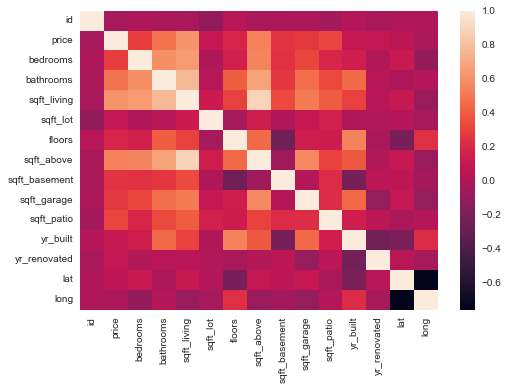

In [4]:
sns.heatmap(df.corr());

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30155 entries, 0 to 30154
Data columns (total 25 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   id             30155 non-null  int64         
 1   date           30155 non-null  datetime64[ns]
 2   price          30155 non-null  float64       
 3   bedrooms       30155 non-null  int64         
 4   bathrooms      30155 non-null  float64       
 5   sqft_living    30155 non-null  int64         
 6   sqft_lot       30155 non-null  int64         
 7   floors         30155 non-null  float64       
 8   waterfront     30155 non-null  object        
 9   greenbelt      30155 non-null  object        
 10  nuisance       30155 non-null  object        
 11  view           30155 non-null  object        
 12  condition      30155 non-null  object        
 13  grade          30155 non-null  object        
 14  heat_source    30123 non-null  object        
 15  sewer_system   3014

### Set Categorical Variables

In [6]:
df['address'][4]

'2193 Northwest Talus Drive, Issaquah, Washington 98027, United States'

In [7]:
zipcode = []

for zips in df['address']:
    zipcode.append(int(zips[-20:-15]))
    
df['zipcode'] = zipcode
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,greenbelt,...,sqft_above,sqft_basement,sqft_garage,sqft_patio,yr_built,yr_renovated,address,lat,long,zipcode
0,7399300360,2022-05-24,675000.0,4,1.0,1180,7140,1.0,NO,NO,...,1180,0,0,40,1969,0,"2102 Southeast 21st Court, Renton, Washington ...",47.461975,-122.19052,98055
1,8910500230,2021-12-13,920000.0,5,2.5,2770,6703,1.0,NO,NO,...,1570,1570,0,240,1950,0,"11231 Greenwood Avenue North, Seattle, Washing...",47.711525,-122.35591,98133
2,1180000275,2021-09-29,311000.0,6,2.0,2880,6156,1.0,NO,NO,...,1580,1580,0,0,1956,0,"8504 South 113th Street, Seattle, Washington 9...",47.502045,-122.22520,98178
3,1604601802,2021-12-14,775000.0,3,3.0,2160,1400,2.0,NO,NO,...,1090,1070,200,270,2010,0,"4079 Letitia Avenue South, Seattle, Washington...",47.566110,-122.29020,98118
4,8562780790,2021-08-24,592500.0,2,2.0,1120,758,2.0,NO,NO,...,1120,550,550,30,2012,0,"2193 Northwest Talus Drive, Issaquah, Washingt...",47.532470,-122.07188,98027


### Drop NaNs

In [8]:
df.isna().sum()

id                0
date              0
price             0
bedrooms          0
bathrooms         0
sqft_living       0
sqft_lot          0
floors            0
waterfront        0
greenbelt         0
nuisance          0
view              0
condition         0
grade             0
heat_source      32
sewer_system     14
sqft_above        0
sqft_basement     0
sqft_garage       0
sqft_patio        0
yr_built          0
yr_renovated      0
address           0
lat               0
long              0
zipcode           0
dtype: int64

In [9]:
df.dropna(inplace=True)

In [10]:
df.isna().sum()

id               0
date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
greenbelt        0
nuisance         0
view             0
condition        0
grade            0
heat_source      0
sewer_system     0
sqft_above       0
sqft_basement    0
sqft_garage      0
sqft_patio       0
yr_built         0
yr_renovated     0
address          0
lat              0
long             0
zipcode          0
dtype: int64

# Train-Test Split

In [11]:
y = df['price']
X = df.drop('price', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=.25)

# Helper Functions

ohe executes 2 transformations, test and train. data for any given input variable: First, we use OneHotEncoder to split up our categorical variables. Second, we run a linear regression on encoded values using .fit(). Then, it takes in a training df ('df'), a test df ('df2') and a column name. Next, it returns the training df and the test df concatenated with newly encoded columns. Lastly, we return a list of these newly encoded column names. 

In [12]:
def ohe(df, df2, column):
    for col in column:
        train = df[[col]]
        ohe = OneHotEncoder(drop='first', sparse=False, handle_unknown="ignore")
        ohe.fit(train)
        encoded_train = ohe.transform(train)
        col_labels = [f"{col}_{f}" for f in ohe.get_feature_names()]
        encoded_train = pd.DataFrame(encoded_train, columns=col_labels, index=df.index)
        df = pd.concat([df, encoded_train], axis=1)
        
        test = df2[[col]]
        encoded_test = ohe.transform(test)
        col_labels = [f"{col}_{f}" for f in ohe.get_feature_names()]
        encoded_test = pd.DataFrame(encoded_test, columns=col_labels, index=df2.index)
        df2 = pd.concat([df2, encoded_test], axis=1)
        
    return df, df2, encoded_train.columns.tolist()

We run a Standard Scaler to scale all the values in the test data and training data so that our models results are in comparable units. Then, we score the scaled data to get the R2 to assess the strength of our model.

In [13]:
def scale_score(x, y, x2, y2):
    scaler = StandardScaler()
    scaler.fit(x)
    X_train_scaled = scaler.transform(x)
    X_test_scaled = scaler.transform(x2)

    lr = LinearRegression()
    lr.fit(X_train_scaled,y_train)

    train_preds = lr.predict(X_train_scaled)
    test_preds = lr.predict(X_test_scaled)
    
    print(f"""training score: {r2_score(y_train, train_preds)}
    test score: {r2_score(y_test, test_preds)}""")
    
    return X_train_scaled, X_test_scaled, train_preds, test_preds

Uses price and predictions to calculate Mean Absolute Error (MAE), Mean Squared Error (MSE) and Root Mean Squared Error (RSME) for the training and testing data sets. We will compare these values to evaluate model performance.

In [14]:
def get_train_test_metrics(y_train, train_preds,
               y_test, test_preds):
    """
    Prints different training and testing metrics, namely R2, MAE, MSE, RMSE
    """
    print("\nTraining Metrics:")
    print(f"R2: {r2_score(y_train, train_preds):.3f}")
    print(f"Mean Absolute Error: {mean_absolute_error(y_train, train_preds):.3f}")
    print(f"Mean Squared Error: {mean_squared_error(y_train, train_preds):.3f}")
    print(f"Root Mean Squared Error: {mean_squared_error(y_train, train_preds, squared=False):.3f}")
    
    print("\nTesting Metrics:")
    print(f"R2: {r2_score(y_test, test_preds):.3f}")
    print(f"Mean Absolute Error: {mean_absolute_error(y_test, test_preds):.3f}")
    print(f"Mean Squared Error: {mean_squared_error(y_test, test_preds):.3f}")
    print(f"Root Mean Squared Error: {mean_squared_error(y_test, test_preds, squared=False):.3f}")

# Outliers

### Price

In [15]:
# calculate 25, 75, iqr, whiskers for 'price'
price_q75, price_q25 = np.percentile(df['price'], [75, 25])
price_iqr = price_q75 - price_q25
price_min = price_q25 - (1.5 * price_iqr)
price_max = price_q75 + (1.5 * price_iqr)

print(f"""price_min: {price_min} 
price_max: {price_max}""")

price_min: -326910.0 
price_max: 2276146.0


In [16]:
df = df[df['price'] >= price_min]
df = df[df['price'] <= price_max]

### Sqft Lot

In [17]:
# calculate 25, 75, iqr, whiskers for 'sqft_lot'
sqft_lot_q25, sqft_lot_q75 = np.percentile(df['sqft_lot'], [25, 75])
sqft_lot_iqr = sqft_lot_q75 - sqft_lot_q25
sqft_lot_min = sqft_lot_q25 - (1.5 * sqft_lot_iqr)
sqft_lot_max = sqft_lot_q75 + (1.5 * sqft_lot_iqr)


print(f"""sqft_lot_min: {sqft_lot_min} 
sqft_lot_max: {sqft_lot_max}""")

sqft_lot_min: -3372.375 
sqft_lot_max: 18228.625


In [18]:
# set df to include everything within the whiskers except the outliers
df = df[df['sqft_lot'] >= sqft_lot_min]
df = df[df['sqft_lot'] <= sqft_lot_max]

# Categorical Variables

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24995 entries, 0 to 30154
Data columns (total 26 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   id             24995 non-null  int64         
 1   date           24995 non-null  datetime64[ns]
 2   price          24995 non-null  float64       
 3   bedrooms       24995 non-null  int64         
 4   bathrooms      24995 non-null  float64       
 5   sqft_living    24995 non-null  int64         
 6   sqft_lot       24995 non-null  int64         
 7   floors         24995 non-null  float64       
 8   waterfront     24995 non-null  object        
 9   greenbelt      24995 non-null  object        
 10  nuisance       24995 non-null  object        
 11  view           24995 non-null  object        
 12  condition      24995 non-null  object        
 13  grade          24995 non-null  object        
 14  heat_source    24995 non-null  object        
 15  sewer_system   2499

In [20]:
df.drop(['id', 'date', 'greenbelt', 'sqft_garage', 'sqft_basement'], axis=1, inplace=True)

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24995 entries, 0 to 30154
Data columns (total 21 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   price         24995 non-null  float64
 1   bedrooms      24995 non-null  int64  
 2   bathrooms     24995 non-null  float64
 3   sqft_living   24995 non-null  int64  
 4   sqft_lot      24995 non-null  int64  
 5   floors        24995 non-null  float64
 6   waterfront    24995 non-null  object 
 7   nuisance      24995 non-null  object 
 8   view          24995 non-null  object 
 9   condition     24995 non-null  object 
 10  grade         24995 non-null  object 
 11  heat_source   24995 non-null  object 
 12  sewer_system  24995 non-null  object 
 13  sqft_above    24995 non-null  int64  
 14  sqft_patio    24995 non-null  int64  
 15  yr_built      24995 non-null  int64  
 16  yr_renovated  24995 non-null  int64  
 17  address       24995 non-null  object 
 18  lat           24995 non-nu

### Bedrooms

In [22]:
bed_count = df['bedrooms'].value_counts()
bed_count

3     11049
4      7607
2      3595
5      2000
6       335
1       279
7        56
0        29
8        29
9        13
10        2
11        1
Name: bedrooms, dtype: int64

In [23]:
#df = df[df['bedrooms'] != 7]
#df = df[df['bedrooms'] != 8]
#df = df[df['bedrooms'] != 9]
#df = df[df['bedrooms'] != 10]
#df = df[df['bedrooms'] != 11]

### Condition

In [24]:
condition_count = df['condition'].value_counts()
condition_count

Average      15562
Good          6569
Very Good     2669
Fair           155
Poor            40
Name: condition, dtype: int64

In [25]:
X_train, X_test, encoded_condition = ohe(X_train, X_test, ['condition'])

In [26]:
X_train['condition'] = X_train['condition'].map({'Very Good': 5, 'Good': 4, 'Average': 3, 'Fair': 2, 'Poor': 1})

In [27]:
X_test['condition'] = X_test['condition'].map({'Very Good': 5, 'Good': 4, 'Average': 3, 'Fair': 2, 'Poor': 1})

### Floors

In [28]:
floor_count = print(df['floors'].value_counts())

1.0    11881
2.0     9757
1.5     2052
3.0     1133
2.5      127
4.0       30
3.5       15
Name: floors, dtype: int64


In [29]:
X_train, X_test, encoded_floors = ohe(X_train, X_test, ['floors'])

In [30]:
#X_train['floors'] = X_train['floors'].map({1.0: 1, 1.5: 1, 2.0: 2, 2.5: 2, 3.0: 3, 3.5: 3, 4.0: 4})

In [31]:
#X_test['floors'] = X_test['floors'].map({1.0: 1, 1.5: 1, 2.0: 2, 2.5: 2, 3.0: 3, 3.5: 3, 4.0: 4})

### Grade

In [32]:
grade_count = print(df['grade'].value_counts())

7 Average        10679
8 Good            8195
9 Better          2692
6 Low Average     2549
10 Very Good       499
5 Fair             289
11 Excellent        56
4 Low               28
3 Poor               5
12 Luxury            3
Name: grade, dtype: int64


In [33]:
X_train, X_test, encoded_grade = ohe(X_train, X_test, ['grade'])

In [34]:
#df = df[df['grade'] != '3 Poor']
#df = df[df['grade'] != '2 Substandard']
#df = df[df['grade'] != '13 Mansion']
#df = df[df['grade'] != '12 Luxury']

### Nuisance

In [35]:
nuisance_count = print(df['nuisance'].value_counts())

NO     20755
YES     4240
Name: nuisance, dtype: int64


In [36]:
X_train, X_test, encoded_nuisance = ohe(X_train, X_test, ['nuisance'])

In [37]:
X_train['nuisance'] = X_train['nuisance'].map({'NO': 0, 'YES': 1})

In [38]:
X_test['nuisance'] = X_test['nuisance'].map({'NO': 0, 'YES': 1})

### View

In [39]:
view_count = df['view'].value_counts()
view_count

NONE         22784
AVERAGE       1362
GOOD           499
EXCELLENT      188
FAIR           162
Name: view, dtype: int64

In [40]:
X_train['view'].fillna('NONE', inplace=True)
X_test['view'].fillna('NONE', inplace=True)

In [41]:
X_train, X_test, encoded_view = ohe(X_train, X_test, ['view'])

In [42]:
X_train['view'] = X_train['view'].map({'EXCELLENT': 5, 'GOOD': 4, 'AVERAGE': 3, 'FAIR': 2, 'NONE': 1})

In [43]:
X_test['view'] = X_test['view'].map({'EXCELLENT': 5, 'GOOD': 4, 'AVERAGE': 3, 'FAIR': 2, 'NONE': 1})

### Waterfront

In [44]:
waterfront_count = print(df['waterfront'].value_counts())

NO     24860
YES      135
Name: waterfront, dtype: int64


In [45]:
X_train, X_test, encoded_waterfront = ohe(X_train, X_test, ['waterfront'])

In [46]:
X_train['waterfront'] = X_train['waterfront'].map({'NO': 0, 'YES': 1})

In [47]:
X_test['waterfront'] = X_test['waterfront'].map({'NO': 0, 'YES': 1})

### Zipcode

In [48]:
zipcode_count = print(df['zipcode'].sort_values().value_counts())

98042    789
98103    740
98117    734
98115    718
98038    697
        ... 
84790      1
85040      1
85207      1
85210      1
99705      1
Name: zipcode, Length: 381, dtype: int64


In [49]:
X_train, X_test, encoded_zipcode = ohe(X_train, X_test, ['zipcode'])

# Models

In [50]:
dummy = DummyRegressor()
dummy.fit(X_train, y_train)
basemodel_dummy_score = dummy.score(X_train, y_train)
test_dummy_score = dummy.score(X_test, y_test)

print(f"""basemodel_dummy_score: {basemodel_dummy_score}

test_dummy_score: {test_dummy_score}""")

basemodel_dummy_score: 0.0

test_dummy_score: -0.0015586307608286276


In [51]:
df.corr()['price'].abs().sort_values(ascending=False)

price           1.000000
sqft_living     0.557443
sqft_above      0.455460
bathrooms       0.425351
bedrooms        0.319087
sqft_patio      0.228120
floors          0.183188
lat             0.081978
yr_renovated    0.064154
sqft_lot        0.059193
yr_built        0.051005
long            0.027920
zipcode         0.025148
Name: price, dtype: float64

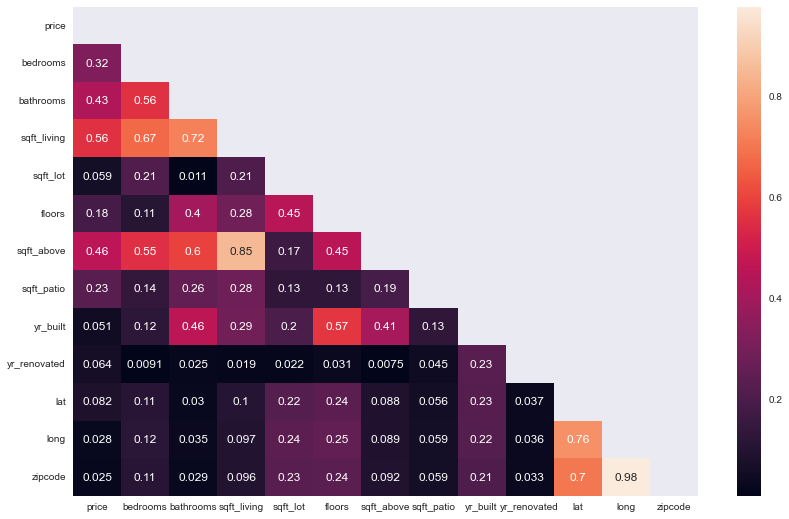

In [52]:
with sns.axes_style("darkgrid"):
    fig, ax = plt.subplots(figsize=(14, 9))
    
    mask = np.triu(np.ones_like(df.corr(), dtype=bool))
    ax = sns.heatmap(abs(df.corr()),mask=mask,annot=True)
    fig.savefig('images/Corelation_Heatmap_22',bbox_inches="tight")

### Model 1

In [53]:
cols = ['sqft_living']

y = y_train
x = X_train.filter(cols, axis=1)

y2 = y_test
x2 = X_test.filter(cols, axis=1)

In [54]:
X_train_scaled, X_test_scaled, train_preds, test_preds = scale_score(x, y, x2, y2)

training score: 0.36595839525329177
    test score: 0.38090762194084116


In [55]:
y_sqft_liv = df['price']
X_sqft_liv = df[['sqft_living']]

model = sm.OLS(y_sqft_liv, sm.add_constant(X_sqft_liv)).fit()
model_summary = model.summary()
model_summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.311
Model:                            OLS   Adj. R-squared:                  0.311
Method:                 Least Squares   F-statistic:                 1.127e+04
Date:                Tue, 02 Aug 2022   Prob (F-statistic):               0.00
Time:                        10:36:52   Log-Likelihood:            -3.5481e+05
No. Observations:               24995   AIC:                         7.096e+05
Df Residuals:                   24993   BIC:                         7.096e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const        3.189e+05   6131.700     52.012      0.000    3.07e+05    3.31e+05
sqft_living   313.4296      2.953    106.150      0.000     307.642     319.217
==============================================================================
Omnibus:                     1384.567   Durbin-Watson:                   2.013
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1737.074
Skew:                           0.553   Prob(JB):                         0.00
Kurtosis:                       3.667   Cond. No.                     5.69e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.69e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Model 2

In [56]:
cols = encoded_zipcode

y = y_train
x = X_train.filter(cols, axis=1)

y2 = y_test
x2 = X_test.filter(cols, axis=1)

In [57]:
X_train_scaled, X_test_scaled, train_preds, test_preds = scale_score(x, y, x2, y2)

training score: 0.3833880772776409
    test score: 0.3668871407270943


In [58]:
get_train_test_metrics(y_train, train_preds, y_test, test_preds)


Training Metrics:
R2: 0.383
Mean Absolute Error: 354584.399
Mean Squared Error: 474549514408.755
Root Mean Squared Error: 688875.543

Testing Metrics:
R2: 0.367
Mean Absolute Error: 379601.249
Mean Squared Error: 572947598553.579
Root Mean Squared Error: 756933.021


### Model 3

In [59]:
cols = ['bathrooms', 'sqft_living', 'sqft_living15', 'zipcode']

y = y_train
x = X_train.filter(cols, axis=1)

y2 = y_test
x2 = X_test.filter(cols, axis=1)

In [60]:
X_train_scaled, X_test_scaled, train_preds, test_preds = scale_score(x, y, x2, y2)

training score: 0.367031192423918
    test score: 0.3823490861851814


In [61]:
get_train_test_metrics(y_train, train_preds, y_test, test_preds)


Training Metrics:
R2: 0.367
Mean Absolute Error: 390727.966
Mean Squared Error: 487137905061.833
Root Mean Squared Error: 697952.652

Testing Metrics:
R2: 0.382
Mean Absolute Error: 405232.932
Mean Squared Error: 558955015099.578
Root Mean Squared Error: 747632.941


### Model 3

In [62]:
cols = ['bedrooms', 'sqft_living', 'sqft_living15']

y = y_train
x = X_train.filter(cols, axis=1)

y2 = y_test
x2 = X_test.filter(cols, axis=1)

In [63]:
X_train_scaled, X_test_scaled, train_preds, test_preds = scale_score(x, y, x2, y2)

training score: 0.38193946761420217
    test score: 0.3984557924548908


In [64]:
get_train_test_metrics(y_train, train_preds, y_test, test_preds)


Training Metrics:
R2: 0.382
Mean Absolute Error: 385219.828
Mean Squared Error: 475664376102.181
Root Mean Squared Error: 689684.258

Testing Metrics:
R2: 0.398
Mean Absolute Error: 400886.566
Mean Squared Error: 544378943009.625
Root Mean Squared Error: 737820.400


### Model 3b

In [65]:
cols = encoded_grade

y = y_train
x = X_train.filter(cols, axis=1)

y2 = y_test
x2 = X_test.filter(cols, axis=1)

In [66]:
X_train_scaled, X_test_scaled, train_preds, test_preds = scale_score(x, y, x2, y2)

training score: 0.39988500468021015
    test score: 0.4205726358888048


In [67]:
get_train_test_metrics(y_train, train_preds, y_test, test_preds)


Training Metrics:
R2: 0.400
Mean Absolute Error: 380763.392
Mean Squared Error: 461853345879.347
Root Mean Squared Error: 679597.930

Testing Metrics:
R2: 0.421
Mean Absolute Error: 399165.197
Mean Squared Error: 524363882270.535
Root Mean Squared Error: 724129.741


### Model 4

In [68]:
cols = encoded_view

y = y_train
x = X_train.filter(cols, axis=1)

y2 = y_test
x2 = X_test.filter(cols, axis=1)

In [69]:
X_train_scaled, X_test_scaled, train_preds, test_preds = scale_score(x, y, x2, y2)

training score: 0.12393985138945429
    test score: 0.10113067142736187


In [70]:
get_train_test_metrics(y_train, train_preds, y_test, test_preds)


Training Metrics:
R2: 0.124
Mean Absolute Error: 491211.955
Mean Squared Error: 674222963903.324
Root Mean Squared Error: 821110.811

Testing Metrics:
R2: 0.101
Mean Absolute Error: 516908.623
Mean Squared Error: 813449001510.750
Root Mean Squared Error: 901914.077


### Model 5

In [71]:
cols = encoded_waterfront

y = y_train
x = X_train.filter(cols, axis=1)

y2 = y_test
x2 = X_test.filter(cols, axis=1)

In [72]:
X_train_scaled, X_test_scaled, train_preds, test_preds = scale_score(x, y, x2, y2)

training score: 0.05850776445372874
    test score: 0.045413217185856114


In [73]:
get_train_test_metrics(y_train, train_preds, y_test, test_preds)


Training Metrics:
R2: 0.059
Mean Absolute Error: 516032.006
Mean Squared Error: 724580026324.385
Root Mean Squared Error: 851222.666

Testing Metrics:
R2: 0.045
Mean Absolute Error: 540586.323
Mean Squared Error: 863871578050.818
Root Mean Squared Error: 929446.921


### Model 6

In [74]:
cols = ['yr_built']

y = y_train
x = X_train.filter(cols, axis=1)

y2 = y_test
x2 = X_test.filter(cols, axis=1)

In [75]:
X_train_scaled, X_test_scaled, train_preds, test_preds = scale_score(x, y, x2, y2)

training score: 0.008552660184951821
    test score: 0.009134156923806258


In [76]:
get_train_test_metrics(y_train, train_preds, y_test, test_preds)


Training Metrics:
R2: 0.009
Mean Absolute Error: 521811.031
Mean Squared Error: 763025877919.864
Root Mean Squared Error: 873513.525

Testing Metrics:
R2: 0.009
Mean Absolute Error: 541657.955
Mean Squared Error: 896703007945.946
Root Mean Squared Error: 946944.036


### Model 7

In [77]:
cols = ['sqft_living'] + encoded_zipcode + encoded_grade + encoded_view

y = y_train
x = X_train.filter(cols, axis=1)

y2 = y_test
x2 = X_test.filter(cols, axis=1)

In [78]:
X_train_scaled, X_test_scaled, train_preds, test_preds = scale_score(x, y, x2, y2)

training score: 0.6587425242749139
    test score: 0.6641746248124185


In [79]:
get_train_test_metrics(y_train, train_preds, y_test, test_preds)


Training Metrics:
R2: 0.659
Mean Absolute Error: 243701.566
Mean Squared Error: 262634508717.755
Root Mean Squared Error: 512478.789

Testing Metrics:
R2: 0.664
Mean Absolute Error: 261166.876
Mean Squared Error: 303911600323.601
Root Mean Squared Error: 551281.779


### Model 8

In [80]:
cols = ['sqft_living'] + encoded_zipcode + encoded_grade + encoded_view + encoded_waterfront

y = y_train
x = X_train.filter(cols, axis=1)

y2 = y_test
x2 = X_test.filter(cols, axis=1)

In [81]:
X_train_scaled, X_test_scaled, train_preds, test_preds = scale_score(x, y, x2, y2)

training score: 0.6680963663210775
    test score: 0.669945577805805


In [82]:
get_train_test_metrics(y_train, train_preds, y_test, test_preds)


Training Metrics:
R2: 0.668
Mean Absolute Error: 244259.183
Mean Squared Error: 255435716353.726
Root Mean Squared Error: 505406.486

Testing Metrics:
R2: 0.670
Mean Absolute Error: 263545.343
Mean Squared Error: 298689065967.367
Root Mean Squared Error: 546524.534


### Model 9

In [83]:
cols = ['bathrooms', 'bedrooms', 'floors', 'sqft_living', 'yr_built'] + encoded_zipcode + encoded_grade + encoded_view + encoded_waterfront

y = y_train
x = X_train.filter(cols, axis=1)

y2 = y_test
x2 = X_test.filter(cols, axis=1)

In [84]:
X_train_scaled, X_test_scaled, train_preds, test_preds = scale_score(x, y, x2, y2)

training score: 0.669274033498424
    test score: 0.6707285135644703


In [85]:
get_train_test_metrics(y_train, train_preds, y_test, test_preds)


Training Metrics:
R2: 0.669
Mean Absolute Error: 243062.238
Mean Squared Error: 254529374185.256
Root Mean Squared Error: 504509.043

Testing Metrics:
R2: 0.671
Mean Absolute Error: 262331.784
Mean Squared Error: 297980533268.688
Root Mean Squared Error: 545875.932
